<a href="https://colab.research.google.com/github/giancarlohc/Applied-AI-in-Transportation/blob/main/Project/ProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Processing


## 1.1 Loading Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install researchpy calmap
import researchpy as rp
import calmap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

url = "https://raw.githubusercontent.com/giancarlohc/Applied-AI-in-Transportation/main/ProjectAssignmentData/Dataset-PT.csv"
dataset = pd.read_csv(url,skiprows=[0])

## 1.2 Data Exploration

In [4]:
dataset

,Calendar_date,route_id,bus_id,stop_sequence,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,...,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,20220108,4,41344,1,151,0,0,120,100,100,...,0,0,0,0,1,0,1,0,0,1
1,20220108,4,41344,2,185,24,171,45,151,100,...,0,0,0,0,1,0,1,0,0,1
2,20220108,4,41344,3,186,0,55,41,185,100,...,0,0,0,0,1,0,1,0,0,1
3,20220108,4,41344,4,202,12,42,94,186,100,...,0,0,0,0,1,0,1,0,0,1
4,20220108,4,41344,5,242,21,98,86,202,100,...,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545098,20220630,4,41362,23,344,13,74,44,341,12,...,0,0,0,0,1,1,0,0,0,1
545099,20220630,4,41362,24,330,15,34,92,344,12,...,0,0,0,0,1,1,0,0,0,1
545100,20220630,4,41362,25,339,17,63,43,330,12,...,0,0,0,0,1,1,0,0,0,1
545101,20220630,4,41362,26,331,0,35,58,339,12,...,0,0,0,0,1,1,0,0,0,1


In [6]:
np.mean(dataset)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


KeyboardInterrupt: ignored

In [ ]:
plt.hist(dataset["arrival_delay"])

In [ ]:
dataset.boxplot(column=["arrival_delay","dwell_time","travel_time_for_previous_section","scheduled_travel_time"])

In [ ]:
dataset.boxplot(column=["upstream_stop_delay","origin_delay","previous_bus_delay","previous_trip_travel_time","traffic_condition","recurrent_delay"])

In [ ]:
np.unique(dataset.isna())

In [ ]:
correlation_matrix = dataset[["arrival_delay","dwell_time","travel_time_for_previous_section","scheduled_travel_time","upstream_stop_delay","origin_delay","previous_bus_delay","previous_trip_travel_time","traffic_condition","recurrent_delay"]].corr()

In [ ]:
plt.figure(figsize=(10, 8))  # Set figure size for better visualization
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
rp.summary_cat(dataset[["weather", "temperature","day_of_week","time_of_day"]])

In [ ]:
plt.hist(dataset["Calendar_date"])

In [ ]:

dates = pd.to_datetime(dataset['Calendar_date'], format='%Y%m%d')

date_frequencies = dates.value_counts().sort_index()

plt.figure(figsize=(12, 6))
date_frequencies.plot(kind='line', linestyle='-', marker='o')
plt.title("Date Frequency")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(16, 10))
calmap.yearplot(date_frequencies, year=2022)
plt.title("Date Frequency Heatmap for 2022")
plt.show()

In [ ]:
dates

In [ ]:
dataset[0:5]['scheduled_travel_time'].sum()/60

## 1.3 Creation of Training Datasets

### 1.3.1 Creation of Datasets with 1,5,10,15,20 Stop Prediction

In [6]:
count = 0
delayed5 = pd.DataFrame()
delayed10 = pd.DataFrame()
delayed15 = pd.DataFrame()
delayed20 = pd.DataFrame()
for k in set(dataset['Calendar_date']):
  buses = set(dataset[dataset["Calendar_date"]==k]["bus_id"])
  for j in buses:
    pullout = dataset[(dataset['bus_id'] == j) & (dataset['Calendar_date'] == k)]

    pullout5 = pullout.copy()
    pullout5['delayed_delay'] = pullout5['arrival_delay'].shift(-4)
    pullout5 = pullout5.dropna()
    delayed5 = pd.concat((delayed5,pullout5),axis=0)

    pullout10 = pullout.copy()
    pullout10['delayed_delay'] = pullout10['arrival_delay'].shift(-9)
    pullout10 = pullout10.dropna()
    delayed10 = pd.concat((delayed10,pullout10),axis=0)

    pullout15 = pullout.copy()
    pullout15['delayed_delay'] = pullout15['arrival_delay'].shift(-14)
    pullout15 = pullout15.dropna()
    delayed15 = pd.concat((delayed15,pullout15),axis=0)

    pullout20 = pullout.copy()
    pullout20['delayed_delay'] = pullout20['arrival_delay'].shift(-19)
    pullout20 = pullout20.dropna()
    delayed20 = pd.concat((delayed20,pullout20),axis=0)

In [7]:
delayed5.to_csv('delayed5.csv', index=False, encoding='utf-8')
delayed10.to_csv('delayed10.csv', index=False, encoding='utf-8')
delayed15.to_csv('delayed15.csv', index=False, encoding='utf-8')
delayed20.to_csv('delayed20.csv', index=False, encoding='utf-8')

In [5]:
#delayed5.to_csv('delayed5.csv', index=False, encoding='utf-8')
#delayed10.to_csv('delayed10.csv', index=False, encoding='utf-8')
#delayed15.to_csv('delayed15.csv', index=False, encoding='utf-8')
#delayed20.to_csv('delayed20.csv', index=False, encoding='utf-8')

delayed5 = pd.read_csv('delayed5.csv')
delayed10 = pd.read_csv('delayed10.csv')
delayed15 = pd.read_csv('delayed15.csv')
delayed20 = pd.read_csv('delayed20.csv')

### 1.3.2 Normalizing the Datasets

Z-Score normalization handles outliers better (many in the dataset and important to detect)

In [6]:
columnnames = dataset.columns
numericcolumns = columnnames[4:14].tolist()
numericcolumns.append("delayed_delay")
factorcolumns = columnnames[18:].tolist()
columnstouse = numericcolumns + factorcolumns

In [5]:
scaler = StandardScaler()
delayed5[numericcolumns] = scaler.fit_transform(delayed5[numericcolumns])
delayed10[numericcolumns] = scaler.fit_transform(delayed10[numericcolumns])
delayed15[numericcolumns] = scaler.fit_transform(delayed15[numericcolumns])
delayed20[numericcolumns] = scaler.fit_transform(delayed20[numericcolumns])

In [7]:
delayed5 = delayed5[columnstouse]
delayed10 = delayed10[columnstouse]
delayed15 = delayed15[columnstouse]
delayed20 = delayed20[columnstouse]

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
delayed5.iloc[:1000,:]
#first_50_columns = delayed5.iloc[:50, :]
#first_50_columns
#Is the rows in the right order? if yes then the delayed delay is wrong

,arrival_delay,dwell_time,travel_time_for_previous_section,scheduled_travel_time,upstream_stop_delay,origin_delay,previous_bus_delay,previous_trip_travel_time,traffic_condition,recurrent_delay,delayed_delay,factor(weather)Light_Rain,factor(weather)Light_Snow,factor(weather)Normal,factor(weather)Rain,factor(weather)Snow,factor(temperature)Cold,factor(temperature)Extra_cold,factor(temperature)Normal,factor(day_of_week)weekday,factor(day_of_week)weekend,factor(time_of_day)Afternoon_peak,factor(time_of_day)Morning_peak,factor(time_of_day)Off-peak
0,-11,0,0,180,4,4,142,219,157.333333,157.544118,54.0,0,0,1,0,0,0,0,1,0,1,0,0,1
1,33,74,165,75,-11,4,201,70,49.333333,52.713235,64.0,0,0,1,0,0,0,0,1,0,1,0,0,1
2,32,30,45,69,33,4,215,47,39.333333,41.639706,65.0,0,0,1,0,0,0,0,1,0,1,0,0,1
3,-6,33,38,156,32,4,254,93,82.666667,93.772059,46.0,0,0,1,0,0,0,0,1,0,1,0,0,1
4,54,71,85,121,-6,4,294,122,106.000000,109.242647,115.0,0,0,1,0,0,0,0,1,0,1,0,0,1
5,64,33,110,52,54,4,332,63,57.000000,49.926471,136.0,0,0,1,0,0,0,0,1,0,1,0,0,1
6,65,24,29,112,64,4,335,77,71.000000,74.529412,96.0,0,0,1,0,0,0,0,1,0,1,0,0,1
7,46,22,89,135,65,4,309,79,84.333333,84.058824,83.0,0,0,1,0,0,0,0,1,0,1,0,0,1
8,115,100,94,66,46,4,322,37,41.333333,40.022059,154.0,0,0,1,0,0,0,0,1,0,1,0,0,1
9,136,43,35,118,115,4,371,116,109.000000,107.397059,166.0,0,0,1,0,0,0,0,1,0,1,0,0,1


### 1.3.3 Splitting the Datasets into Training and Test 80/20%

In [12]:
Y5 = delayed5["delayed_delay"]
X5 = delayed5.drop(columns=["delayed_delay","arrival_delay"])

X5_train, X5_test, Y5_train, Y5_test = train_test_split(X5, Y5, test_size=0.2, random_state=42)

Y10 = delayed10["delayed_delay"]
X10 = delayed10.drop(columns=["delayed_delay","arrival_delay"])

X10_train, X10_test, Y10_train, Y10_test = train_test_split(X10, Y10, test_size=0.2, random_state=42)

Y15 = delayed15["delayed_delay"]
X15 = delayed15.drop(columns=["delayed_delay","arrival_delay"])

X15_train, X15_test, Y15_train, Y15_test = train_test_split(X15, Y15, test_size=0.2, random_state=42)

Y20 = delayed20["delayed_delay"]
X20 = delayed20.drop(columns=["delayed_delay","arrival_delay"])

X20_train, X20_test, Y20_train, Y20_test = train_test_split(X20, Y20, test_size=0.2, random_state=42)

# 2. Model Creation

## 2.1 Model Training

### 2.1.0 Model Training Module 2 - Regression Models

###Linear Regression

###SVR Regression

###XGRegression Regression

In [13]:
#Test Sample
X5_train_SAMPLE =  X5_train.iloc[:500]
X5_test_SAMPLE =   X5_test.iloc[:500]
X10_train_SAMPLE = X10_train.iloc[:500]
X10_test_SAMPLE =  X10_test.iloc[:500]
X15_train_SAMPLE = X15_train.iloc[:500]
X15_test_SAMPLE =  X15_test.iloc[:500]
X20_train_SAMPLE = X20_train.iloc[:500]
X20_test_SAMPLE =  X20_test.iloc[:500]

Y5_train_SAMPLE =  Y5_train.iloc[:500]
Y5_test_SAMPLE =   Y5_test.iloc[:500]
Y10_train_SAMPLE = Y10_train.iloc[:500]
Y10_test_SAMPLE =  Y10_test.iloc[:500]
Y15_train_SAMPLE = Y15_train.iloc[:500]
Y15_test_SAMPLE =  Y15_test.iloc[:500]
Y20_train_SAMPLE = Y20_train.iloc[:500]
Y20_test_SAMPLE =  Y20_test.iloc[:500]

Y5_SAMPLE =  Y5_test.iloc[:500]
X5_SAMPLE =  X5_test.iloc[:500]
Y10_SAMPLE = Y10_test.iloc[:500]
X10_SAMPLE = X10_test.iloc[:500]
Y15_SAMPLE = Y15_test.iloc[:500]
X15_SAMPLE = X15_test.iloc[:500]
Y20_SAMPLE = Y20_test.iloc[:500]
X20_SAMPLE = X20_test.iloc[:500]

# 5 Stops
Best Parameters for Data Size 5: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

Cross-Validation Score for Data Size 5: 0.6896990017014483

Mean Absolute Error for Data Size 5: 0.33488745459535585

Mean Squared Error for Data Size 5: 0.2305519373008081

R-squared for Data Size 5: 0.7662310430087945
# 10 Stops
Best Parameters for Data Size 10: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

Cross-Validation Score for Data Size 10: 0.6896990017014483

Mean Absolute Error for Data Size 10: 0.33488745459535585

Mean Squared Error for Data Size 10: 0.2305519373008081

R-squared for Data Size 10: 0.7662310430087945
# 15 Stops
Best Parameters for Data Size 15: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

Cross-Validation Score for Data Size 15: 0.6896990017014483

Mean Absolute Error for Data Size 15: 0.33488745459535585

Mean Squared Error for Data Size 15: 0.2305519373008081

R-squared for Data Size 15: 0.7662310430087945
# 20 Stops
Best Parameters for Data Size 20: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

Cross-Validation Score for Data Size 20: 0.6896990017014483

Mean Absolute Error for Data Size 20: 0.33488745459535585

Mean Squared Error for Data Size 20: 0.2305519373008081

R-squared for Data Size 20: 0.7662310430087945

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   1.3s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learni

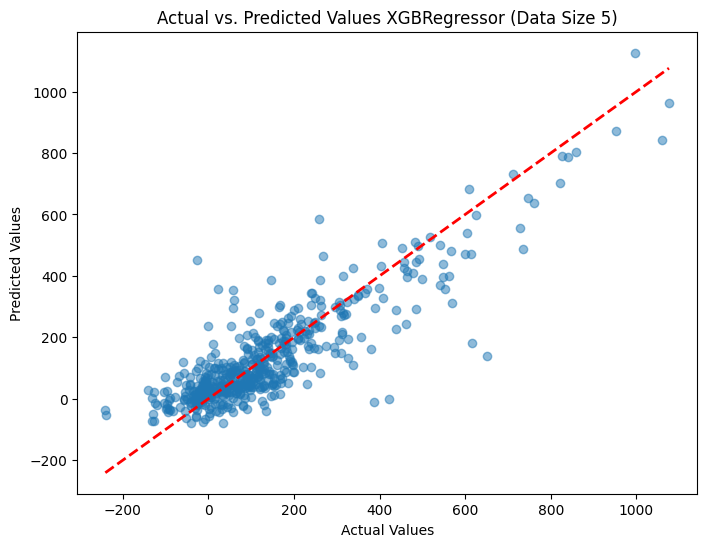

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learni

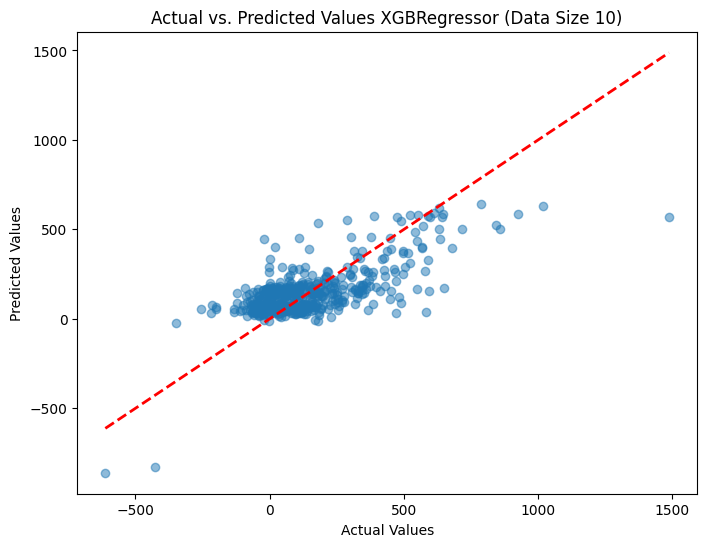

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learni

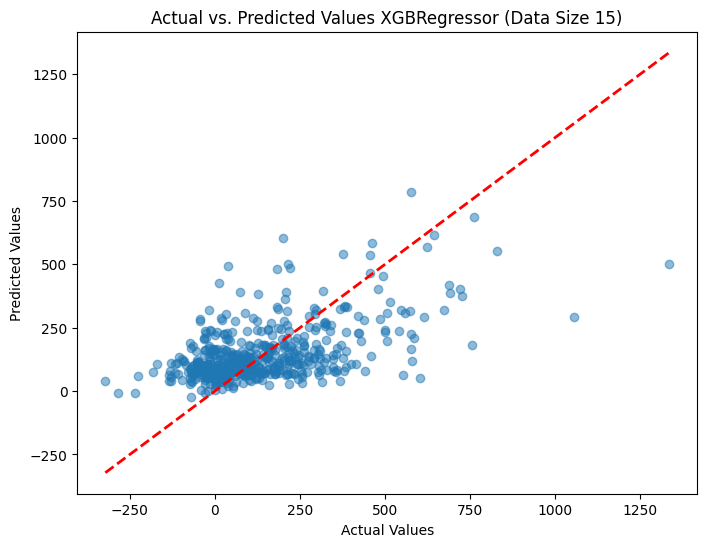

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END gamma=0.01, learni

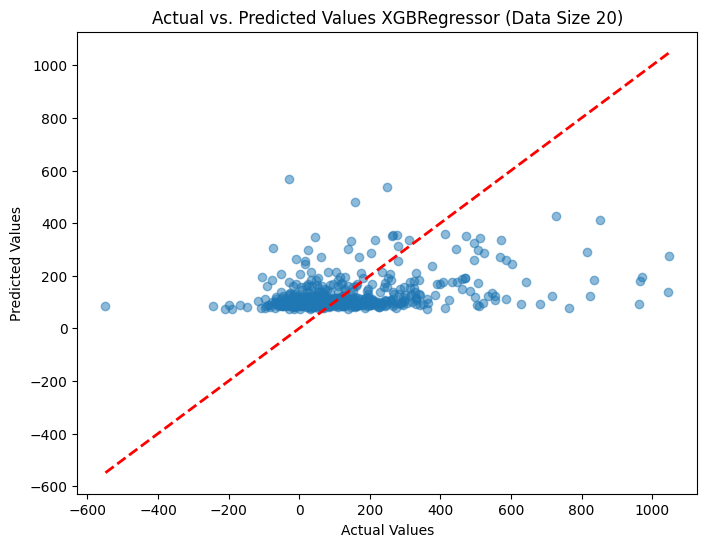

In [14]:

# Define the data sizes
data_sizes = [5, 10, 15, 20]

for size in data_sizes:
    # Create variable names based on the data size
    X_train_SAMPLE = globals()[f"X{size}_train_SAMPLE"]
    X_test_SAMPLE = globals()[f"X{size}_test_SAMPLE"]
    Y_train_SAMPLE = globals()[f"Y{size}_train_SAMPLE"]
    Y_test_SAMPLE = globals()[f"Y{size}_test_SAMPLE"]
    X_SAMPLE = globals()[f"X{size}_SAMPLE"]
    Y_SAMPLE = globals()[f"Y{size}_SAMPLE"]

    # Define hyperparameter search space and model
    params = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'gamma': [0.01, 0.1, 1, 10, 100]
    }

    model = XGBRegressor()

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, params, cv=5, verbose=2, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_SAMPLE, Y_train_SAMPLE)

    # Get the best parameters
    best_params = grid_search.best_params_
    print(f"Best Parameters for Data Size {size}: {best_params}")
    best_score = grid_search.best_score_
    model = grid_search.best_estimator_

    # Cross-validation of the best model
    cv_scores = cross_val_score(model, X_SAMPLE, Y_SAMPLE, cv=5, verbose=1).mean()
    print(f"Cross-Validation Score for Data Size {size}: {cv_scores}")

    # Train the best model on the training data
    model.fit(X_train_SAMPLE, Y_train_SAMPLE)

    # Make predictions and evaluate the model
    y_pred = model.predict(X_test_SAMPLE)
    mae = mean_absolute_error(Y_test_SAMPLE, y_pred)
    mse = mean_squared_error(Y_test_SAMPLE, y_pred)
    r2 = r2_score(Y_test_SAMPLE, y_pred)
    print(f"Mean Absolute Error for Data Size {size}: {mae}")
    print(f"Mean Squared Error for Data Size {size}: {mse}")
    print(f"R-squared for Data Size {size}: {r2}")

    # Visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(Y_test_SAMPLE, y_pred, alpha=0.5)  # Plot actual vs. predicted values
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs. Predicted Values XGBRegressor (Data Size {size})")
    plt.plot([min(Y_test_SAMPLE), max(Y_test_SAMPLE)], [min(Y_test_SAMPLE), max(Y_test_SAMPLE)], linestyle='--', color='red', lw=2)
    plt.show()

###KNN Regression

### 2.1.3  Model Training Module 6 - Do we need to make Reduction?

### 2.1.4 Model Training Module 7 - Nural Network Models

In [ ]:
#-------------------------------------------------network construction------------------------------------------------------------------

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=["Layers", "Dropout Rate", "Learning Rate", "MAE"])

# Search parameters
layer_configs = [[32, 64], [64, 128, 64], [128, 256, 128, 64]]
dropout_rates = [0.2, 0.3, 0.4]
learning_rates = [0.001, 0.0001]

for config in layer_configs:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:

            model = Sequential()

            # Add layers from config
            model.add(Dense(config[0], activation='relu', input_dim=22))
            for units in config[1:]:
                model.add(Dense(units, activation='relu'))
                model.add(Dropout(dropout_rate))

            model.add(Dense(1))

            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

            # Callbacks
            early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)

            # Train without verbose and without ModelCheckpoint for simplicity
            hist = model.fit(X5_train, Y5_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stop, reduce_lr], verbose=0)

            val_mae = min(hist.history['val_mae'])

            # Append results to the DataFrame
            results_df = results_df.append({
                "Layers": str(config),
                "Dropout Rate": dropout_rate,
                "Learning Rate": learning_rate,
                "MAE": val_mae
            }, ignore_index=True)

# Print the results in a tabular form
print(results_df)

# To find the best configuration, sort the DataFrame based on MAE
best_row = results_df.sort_values(by="MAE").iloc[0]
print("\nBest Configuration:")
print(best_row)

## 2.2 Model Evaluation

What type of model is the best performer?

# 3. Model Optimization

Optimization of the parameters of the best performing model type.